# Sandbox for testing and demonstrating augmentations.

In [1]:
# cd into project directory 
%cd /home/baldeeb/Documents/Projects/ContrastiveLearningOfDenseDescriptor

%load_ext autoreload
%autoreload 2

import numpy as np
import torch
# import torch.nn.functional as F 

# from scipy.spatial.transform import Rotation as R

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

/home/baldeeb/Documents/Projects/ContrastiveLearningOfDenseDescriptor


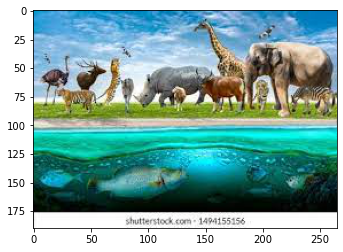

In [2]:
def image_to_tensor(img): 
    t = torch.tensor(np.asarray(img).astype(float), requires_grad=True, dtype=torch.float32)
    t = t.permute(2, 0, 1).unsqueeze(0) / 255.0
    return t

def tensor_to_image(t, extension='jpg'):
    if extension == 'jpg':    
        im = t.squeeze(0).permute(1,2,0) * 255.0   # works for JPG
        return im.type(torch.int).numpy()
    elif extension == 'png':
        im = t.squeeze(0).permute(1,2,0).detach().numpy()  # Works for PNG
        return im * 255.0
    else:
        print('shshshshsit.....')

img = mpimg.imread("temp/sample_image.jpeg")
im = image_to_tensor(img)
im_batch, im_ch, im_h, im_w = im.shape
img = tensor_to_image(im)
plt.imshow(img)

In [3]:
def visualize_transform(im, transform):
    fig = plt.figure()
    # fig.tight_layout()
    gs = fig.add_gridspec(1, 4)
    axs = gs.subplots()

    for ax in axs: 
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    axs[0].imshow(tensor_to_image(im))

    resized_im = transform.forward(im)
    axs[1].imshow(tensor_to_image(resized_im))

    inv_results = transform.get_inverse()(resized_im)
    axs[2].imshow(tensor_to_image(inv_results))

    delta = im - inv_results
    axs[3].imshow(tensor_to_image(delta))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


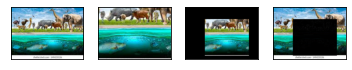

In [4]:
from transforms import RandomResizedCrop
resize_crop = RandomResizedCrop([im_h, im_w])
visualize_transform(im, resize_crop)

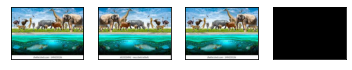

In [5]:
from transforms import RandomHorizontalFlip
flip = RandomHorizontalFlip(0.9)
visualize_transform(im, flip)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


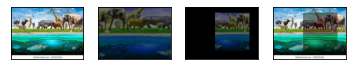

In [7]:
from geometrically_invertible_aug import GeometricallyInvertibleAugmentation
aug = GeometricallyInvertibleAugmentation([im_h, im_w])

fig = plt.figure()
gs = fig.add_gridspec(1, 4)
axs = gs.subplots()

for ax in axs: 
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)


axs[0].imshow(tensor_to_image(im))

resized_im = aug(im)
axs[1].imshow(tensor_to_image(resized_im))

inv_results = aug.geometric_inverse(resized_im)
axs[2].imshow(tensor_to_image(inv_results))

delta = im - inv_results
axs[3].imshow(tensor_to_image(delta))

In [7]:
import torch 
m1, m2 = torch.randint(0, 10, (2,4)), torch.randint(0, 10, (2,4))


def get_sorted_list_of_nonzero_indices_and_their_values(m):
    '''
    input shape: 
    '''
    indices = (m != 0).nonzero().T
    values = m[indices[0], indices[1]]
    sorted_values, i = torch.sort(values)
    sorted_indices = indices[:, i]
    return sorted_indices, sorted_values

def get_matches_from_int_masks(m1, m2):
    '''
    given 2 masks with integer values, returns lists of indices that which have the same integer in mask.
    
    mask shape: 
    '''
    i1, v1 = get_sorted_list_of_nonzero_indices_and_their_values(m1) 
    i2, v2 = get_sorted_list_of_nonzero_indices_and_their_values(m2)
    print(v1.shape, v2.shape) 
    v1_expanded = v1.expand((v2.shape[0], v1.shape[0])).T
    print(v1_expanded.shape)
    diff = (v1_expanded  - v2)
    matching_indices = (diff == 0).nonzero()
    if matching_indices.shape[0] == 0: return torch.tensor([]), torch.tensor([])
    v1_indices, v2_indices = [matching_indices[:, i].flatten() for i in range(2)]
    return v1[v1_indices], v2[v2_indices]

get_matches_from_int_masks(m1, m2)


torch.Size([5]) torch.Size([6])
torch.Size([5, 6])


(tensor([4, 8]), tensor([4, 8]))

# Testing augmentation.util functions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image shape: torch.Size([1, 3, 190, 265])
image:   mean: 0.509800136089325,  std: 0.319646954536438
augmented:   mean: -1.1488069295883179,  std: 3.6474087238311768

image shape: torch.Size([1, 3, 190, 265])
image:   mean: 0.509800136089325,  std: 0.319646954536438
augmented:   mean: -1.1488069295883179,  std: 3.6474087238311768

tensor(-9.9848, grad_fn=<MinBackward1>) tensor(4.5931, grad_fn=<MaxBackward1>)
tensor(-9.9848, grad_fn=<MinBackward1>) tensor(4.5931, grad_fn=<MaxBackward1>)


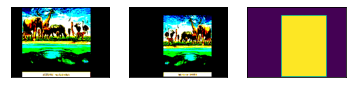

In [8]:
from augmentations.util import union_of_augmented_images_in_original
from augmentations.geometrically_invertible_aug import GeometricallyInvertibleAugmentation as Augmentor

num_augs = 2
augmentors = [Augmentor(im.shape[-2:]) for i in range(num_augs)]
augmented_ims = [aug(im) for aug in augmentors]

for i in augmented_ims:
    print(i.min(), i.max())

de_augmented_ims = [aug.geometric_inverse(x) for aug, x in zip(augmentors, augmented_ims)]

mask = union_of_augmented_images_in_original(augmentors, im.shape[-2:])

## Visualize
fig = plt.figure()
gs = fig.add_gridspec(1, num_augs+1)
axs = gs.subplots()

for ax in axs: 
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

for i in range(num_augs):
    axs[i].imshow(tensor_to_image(de_augmented_ims[i]))

axs[num_augs].imshow(tensor_to_image(mask.unsqueeze(0).unsqueeze(0)))

In [1]:
plt.figure()
plt.imshow(tensor_to_image(augmented_ims[1]))
plt.figure()
plt.imshow(tensor_to_image(de_augmented_ims[1]))


NameError: name 'plt' is not defined